In [1]:
%matplotlib inline
import matplotlib.pyplot as plt      
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam


## Sine Wave to test with Wavenet

In [2]:
sine_wave = np.sin(np.arange(0, 10, 0.1))

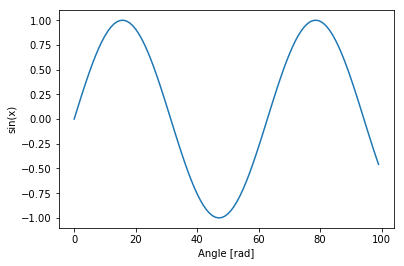

In [3]:
plt.plot(sine_wave)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight');


## Encoding from the first wavenet paper, tacotron2 uses MoL encoding instead

In [4]:
def mu_law_encode(signal, mu=256):
    """
    Quantizes a signal to mu number discrete values.
    """
    mu = mu-1
    fx = np.sign(signal) * (np.log(1 + mu*np.abs(signal))/
                           np.log(1 + mu))
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)


def decode_mu_law(quantized_signal, mu=256):
    mu = mu-1
    fx = (quantized_signal-0.5)/mu*2-1
    x = (np.sign(fx)/
         mu*((1+mu)**np.abs(fx)-1))
    return x
    

In [5]:
mu_sine = mu_law_encode(sine_wave)

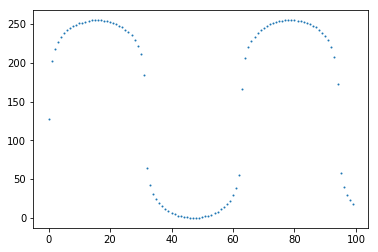

In [6]:
plt.plot(mu_sine,'.', ms=2);

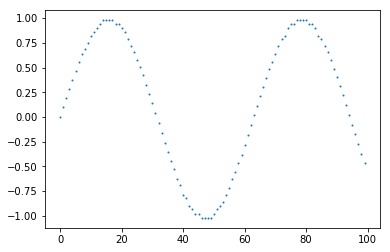

In [7]:
plt.plot(decode_mu_law(mu_sine), '.', ms=2);

## Causal Convolution

In [8]:
class CausalConv1d(nn.Module):
    """
    pads the left side of input sequence just enough so that the convolutional kernel
    does not look into the future.
    
    Input and output sizes will be the same.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[:, :, :-self.conv1.padding[0]]  # remove trailing padding
        return x

In [9]:
class ResidualLayer(nn.Module):
    """
    A wavenet causal gated residual layer
    """
    
    def __init__(self, residual_channels, skip_channels, dilation):
        super(ResidualLayer, self).__init__()
        self.conv_filter = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=2, dilation=dilation)
        self.conv_gate = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=2, dilation=dilation)
        
        self.resconv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skipconv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)
        
    def forward(self, x):
        conv_filter = self.conv_filter(x)
        conv_gate = self.conv_gate(x)
        fx = F.tanh(conv_filter) * F.sigmoid(conv_gate)
        fx = self.resconv(fx) # restore feature dims with 
        skip = self.skipconv(fx)  # conv1x1 goes to skip connections
        residual = fx + x  # residual output goes to next layer
        return skip, residual
        

In [10]:
class DilatedStack(nn.Module):
    def __init__(self, residual_channels, skip_channels, num_dilations=10):
        """
        Block of dilated residual layers
        Dilation increases exponentially, final dilation will be 2**num_layers.
        a 10 layer block has a receptive field of 1024 (kernel_size * dilation)
        """
        super(DilatedStack, self).__init__()
        residual_stack = [ResidualLayer(residual_channels, skip_channels, dilation=2**layer)
                         for layer in range(num_dilations)]
        self.residual_stack = nn.ModuleList(residual_stack)
        
    def forward(self, x):
        skips = []
        for layer in self.residual_stack:
            skip, x = layer(x)
            skips.append(skip.unsqueeze(0))
        return torch.cat(skips, dim=0), x  # layers, batch, features, seq
    

In [11]:
class WaveNet(nn.Module):
    def __init__(self):
        super(WaveNet, self).__init__()
        self.embed = nn.Embedding(num_embeddings=256, embedding_dim=256) # 1, 100, 32
        self.input_conv = CausalConv1d(in_channels=256, out_channels=512, kernel_size=2)
        self.block1 = WaveNetBlock(residual_channels=512, skip_channels=256, num_dilations=10)
        self.block2 = WaveNetBlock(residual_channels=512, skip_channels=256, num_dilations=10)
        self.convout = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=1)
        
    def forward(self, x):
        x = self.embed(x) # [1, 100, 32] 
        x = x.transpose(1, 2)  # [1, 32, 100]
        x = self.input_conv(x) # [1, 32, 100]
        skips1, residual = self.block1(x) # [5, 1, 16, 100] and [1, 32, 100]
        skips2, _ = self.block2(residual) # [5, 1, 16, 100] and [1, 32, 100]
        skips = torch.cat([skips1, skips2], dim=0) # [10, 1, 16, 100]
        out = skips.sum(dim=0) # [1, 16, 100]
        out = F.relu(out)
        out = self.convout(out) # [1, 256, 100]
        return out
    
    def generate(self, start, maxlen=100):
        outputs = [start]
        for i in range(maxlen):
            probs = self.forward(torch.cat(outputs, dim=1)) # P(all_next|all previous)
            _, output = probs[..., -1:].max(dim=1) # get prob for the last word and take max idx
            outputs.append(output)
        return torch.cat(outputs[1:])
     

In [12]:
wavenet = WaveNet()

In [13]:
wavenet.cuda()

WaveNet(
  (embed): Embedding(256, 256)
  (input_conv): CausalConv1d(
    (conv1): Conv1d(256, 512, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (block1): WaveNetBlock(
    (residual_stack): ModuleList(
      (0): ResidualLayer(
        (conv_filter): CausalConv1d(
          (conv1): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,))
        )
        (conv_gate): CausalConv1d(
          (conv1): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,))
        )
        (resconv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
        (skipconv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualLayer(
        (conv_filter): CausalConv1d(
          (conv1): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
        )
        (conv_gate): CausalConv1d(
          (conv1): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
        )
        (resconv): Conv1d(512, 512, kernel_size=(1,), stri

In [14]:
optimizer = Adam(wavenet.parameters())

In [15]:
def sine_generator(seq_size= 6000, mu=256):
    framerate = 44100
    t = np.linspace(0,5,framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = mu_law_encode(ys,mu)
        yield Variable(torch.from_numpy(ys[:seq_size]).unsqueeze(0)).cuda()

In [53]:
g = sine_generator(seq_size=3000)
for i in range(100): 
    batch = next(g)
    x = batch[:, :-1]
    y = batch[:, 1:]
    out = wavenet(x)
    loss = F.cross_entropy(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(loss.data[0])

0.05180001258850098
0.07983175665140152


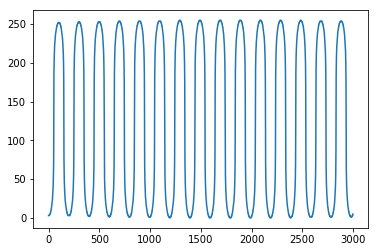

In [ ]:
plt.plot(next(g).data[0])

In [ ]:
%time gen_wave = wavenet.generate(x[:,:1], maxlen=300)

In [ ]:
plt.plot(gen_wave.data);